### *This code was extracted from https://colab.research.google.com/github/reiinakano/invariant-risk-minimization/blob/master/invariant_risk_minimization_colored_mnist.ipynb*

## Prepare the colored MNIST dataset

We define three environments (two training, one test) by randomly splitting the MNIST dataset in thirds and transforming each example as follows:
1. Assign a binary label y to the image based on the digit: y = 0 for digits 0-4
and y = 1 for digits 5-9.
2. Flip the label with 25% probability.
3. Color the image either red or green according to its (possibly flipped) label.
4. Flip the color with a probability e that depends on the environment: 20% in
the first training environment, 10% in the second training environment, and
90% in the test environment.

In [1]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils

In [2]:
def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr,
                          np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                          arr,
                          np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
    Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

    Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
        transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
    """
    def __init__(self, root='./data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(
            root, transform=transform, target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(
                os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                    torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
            and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
            and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
                print('Colored MNIST dataset already exists')
                return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)

            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

            # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

            # Flip the color with a probability e that depends on the environment
            if idx < 20000:
                # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.1:
                    color_red = not color_red
            else:
                # 90% in the test environment
                if np.random.uniform() < 0.9:
                    color_red = not color_red

            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 20000:
                train1_set.append((Image.fromarray(colored_arr), binary_label))
            elif idx < 40000:
                train2_set.append((Image.fromarray(colored_arr), binary_label))
            else:
                test_set.append((Image.fromarray(colored_arr), binary_label))

            # Debug
#             print('original label', type(label), label)
#             print('binary label', binary_label)
#             print('assigned color', 'red' if color_red else 'green')
#             plt.imshow(colored_arr)
#             plt.show()
#             break

#         dataset_utils.makedir_exist_ok(colored_mnist_dir)
        os.makedirs(colored_mnist_dir, exist_ok=True)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))


In [3]:
def plot_dataset_digits(dataset):
    fig = plt.figure(figsize=(13, 8))
    columns = 6
    rows = 3
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns * rows):
        img, label = dataset[i]
        # create subplot and append to ax
        ax.append(fig.add_subplot(rows, columns, i + 1))
        ax[-1].set_title("Label: " + str(label))  # set title
        plt.imshow(img)

    plt.show()  # finally, render the plot


Colored MNIST dataset already exists
Dataset ColoredMNIST
    Number of datapoints: 20000
    Root location: ./data


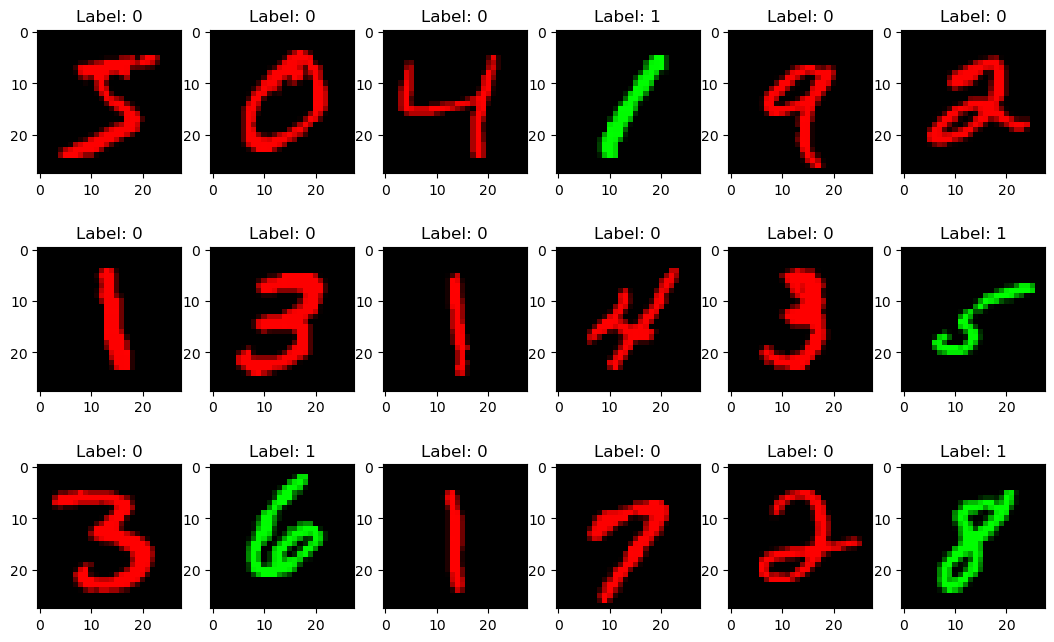

In [4]:
train1_set = ColoredMNIST(root='./data', env='train1')
print(train1_set)
plot_dataset_digits(train1_set)

Colored MNIST dataset already exists
Dataset ColoredMNIST
    Number of datapoints: 20000
    Root location: ./data


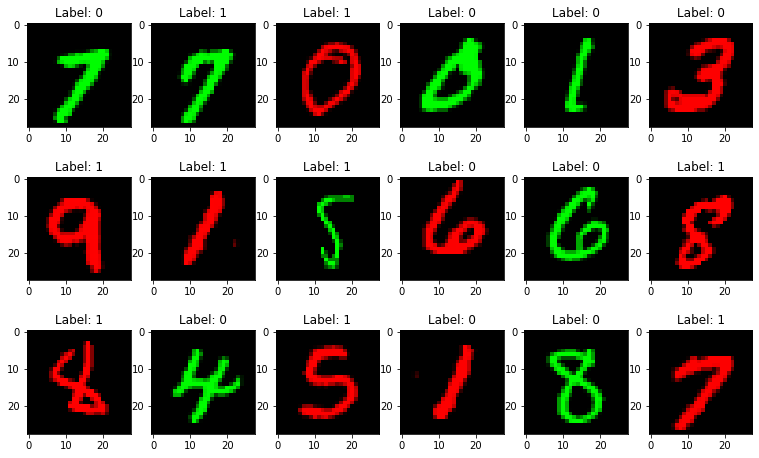

In [5]:
test_set = ColoredMNIST(root='./data', env='test')
print(test_set)
plot_dataset_digits(test_set)

Colored MNIST dataset already exists
Dataset ColoredMNIST
    Number of datapoints: 40000
    Root location: ./data


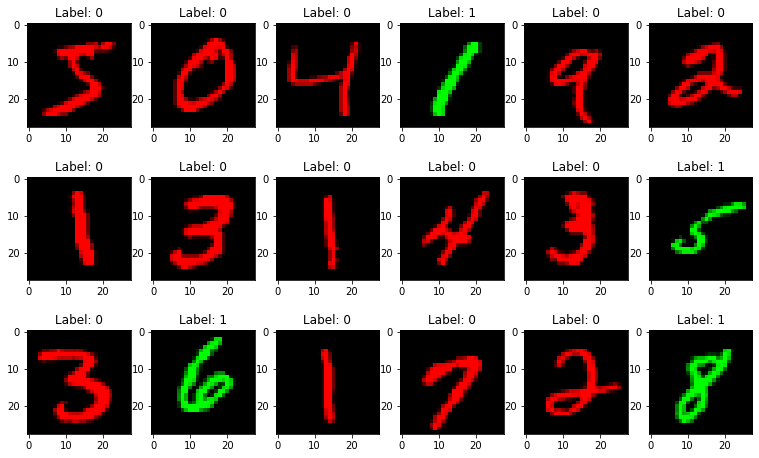

In [6]:
all_train_set = ColoredMNIST(root='./data', env='all_train')
print(all_train_set)
plot_dataset_digits(all_train_set)
torch.save(all_train_set, os.path.join("./data/ColoredMNIST", 'all_training.pt'))